# Нейросети для картинок на примере MNIST и mxnet
https://github.com/dmlc/mxnet

In [1]:
import mxnet as mx
import numpy as np
import logging
import sys
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
%pylab inline
figsize(12, 6)
%config InlineBackend.figure_formats=['retina']

# для вывода mxnet в ноутбук
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
logging.getLogger().setLevel(logging.DEBUG)

Populating the interactive namespace from numpy and matplotlib


# Скачиваем MNIST датасет

In [7]:
! wget http://webdocs.cs.ualberta.ca/~bx3/data/mnist.zip
! unzip -u mnist.zip; rm mnist.zip

--2016-04-29 09:52:02--  http://webdocs.cs.ualberta.ca/~bx3/data/mnist.zip
Resolving webdocs.cs.ualberta.ca (webdocs.cs.ualberta.ca)... 64:ff9b::8180:b806
Connecting to webdocs.cs.ualberta.ca (webdocs.cs.ualberta.ca)|64:ff9b::8180:b806|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11595270 (11M) [application/zip]
Saving to: `mnist.zip'

100%[======================================>] 11,595,270  2.66M/s   in 5.7s    

2016-04-29 09:52:08 (1.95 MB/s) - `mnist.zip' saved [11595270/11595270]

Archive:  mnist.zip
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  


# Символы с архитектурой сети

In [2]:
def get_mlp():
    """
    multi-layer perceptron
    """
    data = mx.symbol.Variable('data')
    fc1  = mx.symbol.FullyConnected(data = data, name='fc1', num_hidden=128)
    act1 = mx.symbol.Activation(data = fc1, name='relu1', act_type="relu")
    fc2  = mx.symbol.FullyConnected(data = act1, name = 'fc2', num_hidden = 64)
    act2 = mx.symbol.Activation(data = fc2, name='relu2', act_type="relu")
    fc3  = mx.symbol.FullyConnected(data = act2, name='fc3', num_hidden=10)
    mlp  = mx.symbol.SoftmaxOutput(data = fc3, name = 'softmax')
    return mlp

def get_lenet():
    """
    LeCun, Yann, Leon Bottou, Yoshua Bengio, and Patrick
    Haffner. "Gradient-based learning applied to document recognition."
    Proceedings of the IEEE (1998)
    """
    data = mx.symbol.Variable('data')
    # first conv
    conv1 = mx.symbol.Convolution(data=data, kernel=(5,5), num_filter=20)
    tanh1 = mx.symbol.Activation(data=conv1, act_type="tanh")
    pool1 = mx.symbol.Pooling(data=tanh1, pool_type="max",
                              kernel=(2,2), stride=(2,2))
    # second conv
    conv2 = mx.symbol.Convolution(data=pool1, kernel=(5,5), num_filter=50)
    tanh2 = mx.symbol.Activation(data=conv2, act_type="tanh")
    pool2 = mx.symbol.Pooling(data=tanh2, pool_type="max",
                              kernel=(2,2), stride=(2,2))
    # first fullc
    flatten = mx.symbol.Flatten(data=pool2)
    fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
    tanh3 = mx.symbol.Activation(data=fc1, act_type="tanh")
    # second fullc
    fc2 = mx.symbol.FullyConnected(data=tanh3, num_hidden=10)
    # loss
    lenet = mx.symbol.SoftmaxOutput(data=fc2, name='softmax')
    return lenet

# Что такое MNIST?

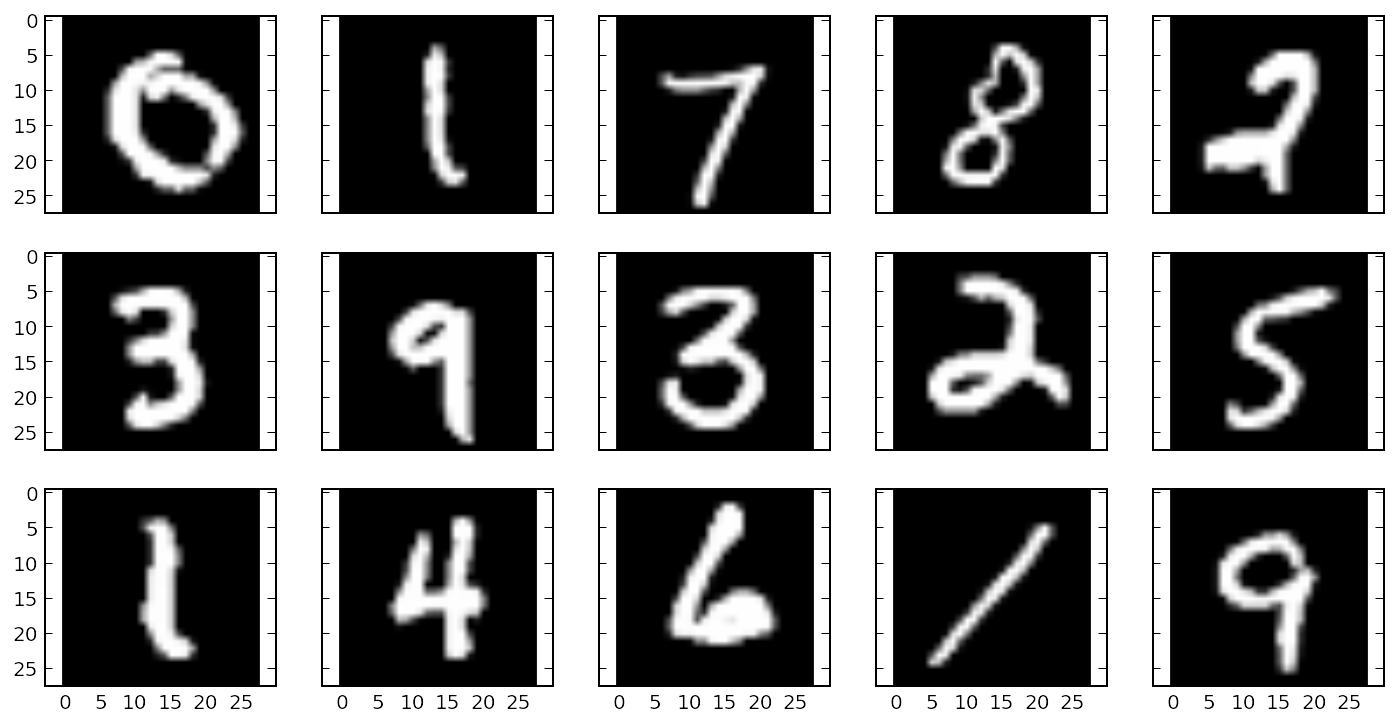

In [3]:
# итератор mxnet для чтения данных
train_data = mx.io.MNISTIter(
    image       = "train-images-idx3-ubyte",
    label       = "train-labels-idx1-ubyte",
    input_shape = (1, 28, 28),
    batch_size  = 1,
    shuffle     = True,
    flat        = False
)

n_rows = 3
n_cols = 5
f, axarr = plt.subplots(n_rows, n_cols, sharex=True, sharey=True)
for i in range(n_rows):
    for j in range(n_cols):
        axarr[i, j].imshow(train_data.next().data[0].asnumpy()[0][0, :, :], cmap='Greys_r')

# Обучение

In [4]:
def train_net(net, data_shape, batch_size):
    # итераторы для картинок
    flat = False if len(data_shape) == 3 else True
    
    train_data = mx.io.MNISTIter(
        image       = "train-images-idx3-ubyte",
        label       = "train-labels-idx1-ubyte",
        input_shape = data_shape,
        batch_size  = batch_size,
        shuffle     = True,
        flat        = flat)

    test_data = mx.io.MNISTIter(
        image       = "t10k-images-idx3-ubyte",
        label       = "t10k-labels-idx1-ubyte",
        input_shape = data_shape,
        batch_size  = batch_size,
        flat        = flat)
    
    # модель из символа сети
    model = mx.model.FeedForward(
        ctx                = [mx.gpu(2), mx.gpu(3)],  # для обучения на GPU
        # ctx                = [mx.cpu(idx) for idx in range(16)],  # для обучения на CPU, укажите сколько ядер использовать (работает только с одним процессором в системе)
        symbol             = net,
        num_epoch          = 10,
        learning_rate      = 0.05,
        momentum           = 0.9,
        wd                 = 0.00001,
        initializer        = mx.init.Xavier(factor_type="in", magnitude=2.34),  # инициализация весов
        lr_scheduler       = mx.lr_scheduler.FactorScheduler(90000 / batch_size, 0.8)  # через сколько батчей умножать learning_rate на 0.8
    )
    
    # обучение
    model.fit(
        X                  = train_data,
        eval_data          = test_data,
        eval_metric        = ['accuracy'],
        batch_end_callback = [mx.callback.Speedometer(batch_size, 500)]  # выводить каждые 500 бачтей инфу о скорости
    )
    
    return model

In [5]:
model = train_net(get_mlp(), (784,), batch_size=512)

Auto-select kvstore type = local_update_cpu
Start training with [gpu(2), gpu(3)]
Epoch[0] Resetting Data Iterator
Epoch[0] Train-accuracy=0.800214
Epoch[0] Time cost=3.021
Epoch[0] Validation-accuracy=0.914371
Update[176]: Change learning rate to 4.00000e-02
Epoch[1] Resetting Data Iterator
Epoch[1] Train-accuracy=0.929554
Epoch[1] Time cost=0.228
Epoch[1] Validation-accuracy=0.947060
Update[351]: Change learning rate to 3.20000e-02
Epoch[2] Resetting Data Iterator
Epoch[2] Train-accuracy=0.949402
Epoch[2] Time cost=0.231
Epoch[2] Validation-accuracy=0.956106
Epoch[3] Resetting Data Iterator
Epoch[3] Train-accuracy=0.958734
Epoch[3] Time cost=0.233
Epoch[3] Validation-accuracy=0.961760
Update[526]: Change learning rate to 2.56000e-02
Epoch[4] Resetting Data Iterator
Epoch[4] Train-accuracy=0.964460
Epoch[4] Time cost=0.231
Epoch[4] Validation-accuracy=0.966077
Update[701]: Change learning rate to 2.04800e-02
Epoch[5] Resetting Data Iterator
Epoch[5] Train-accuracy=0.968733
Epoch[5] Tim

In [6]:
model = train_net(get_lenet(), (1, 28, 28), batch_size=128)

Auto-select kvstore type = local_update_cpu
Start training with [gpu(2), gpu(3)]
Epoch[0] Resetting Data Iterator
Epoch[0] Train-accuracy=0.945997
Epoch[0] Time cost=2.145
Epoch[0] Validation-accuracy=0.981871
Update[704]: Change learning rate to 4.00000e-02
Epoch[1] Resetting Data Iterator
Epoch[1] Train-accuracy=0.986128
Epoch[1] Time cost=2.129
Epoch[1] Validation-accuracy=0.988882
Epoch[2] Resetting Data Iterator
Epoch[2] Train-accuracy=0.991236
Epoch[2] Time cost=2.106
Epoch[2] Validation-accuracy=0.990284
Update[1407]: Change learning rate to 3.20000e-02
Epoch[3] Resetting Data Iterator
Epoch[3] Train-accuracy=0.994792
Epoch[3] Time cost=2.112
Epoch[3] Validation-accuracy=0.991186
Update[2110]: Change learning rate to 2.56000e-02
Epoch[4] Resetting Data Iterator
Epoch[4] Train-accuracy=0.996778
Epoch[4] Time cost=2.124
Epoch[4] Validation-accuracy=0.990585
Epoch[5] Resetting Data Iterator
Epoch[5] Train-accuracy=0.998047
Epoch[5] Time cost=2.123
Epoch[5] Validation-accuracy=0.990

# Какие получились фильтрики? (для lenet)

In [7]:
# Все параметры модели
model.arg_params

{'convolution0_bias': <mxnet.ndarray.NDArray at 0x25661810>,
 'convolution0_weight': <mxnet.ndarray.NDArray at 0x25661410>,
 'convolution1_bias': <mxnet.ndarray.NDArray at 0x25661790>,
 'convolution1_weight': <mxnet.ndarray.NDArray at 0x256617d0>,
 'fullyconnected0_bias': <mxnet.ndarray.NDArray at 0x25661910>,
 'fullyconnected0_weight': <mxnet.ndarray.NDArray at 0x256618d0>,
 'fullyconnected1_bias': <mxnet.ndarray.NDArray at 0x25661990>,
 'fullyconnected1_weight': <mxnet.ndarray.NDArray at 0x25661950>}

In [8]:
filters = model.arg_params["convolution0_weight"].asnumpy()

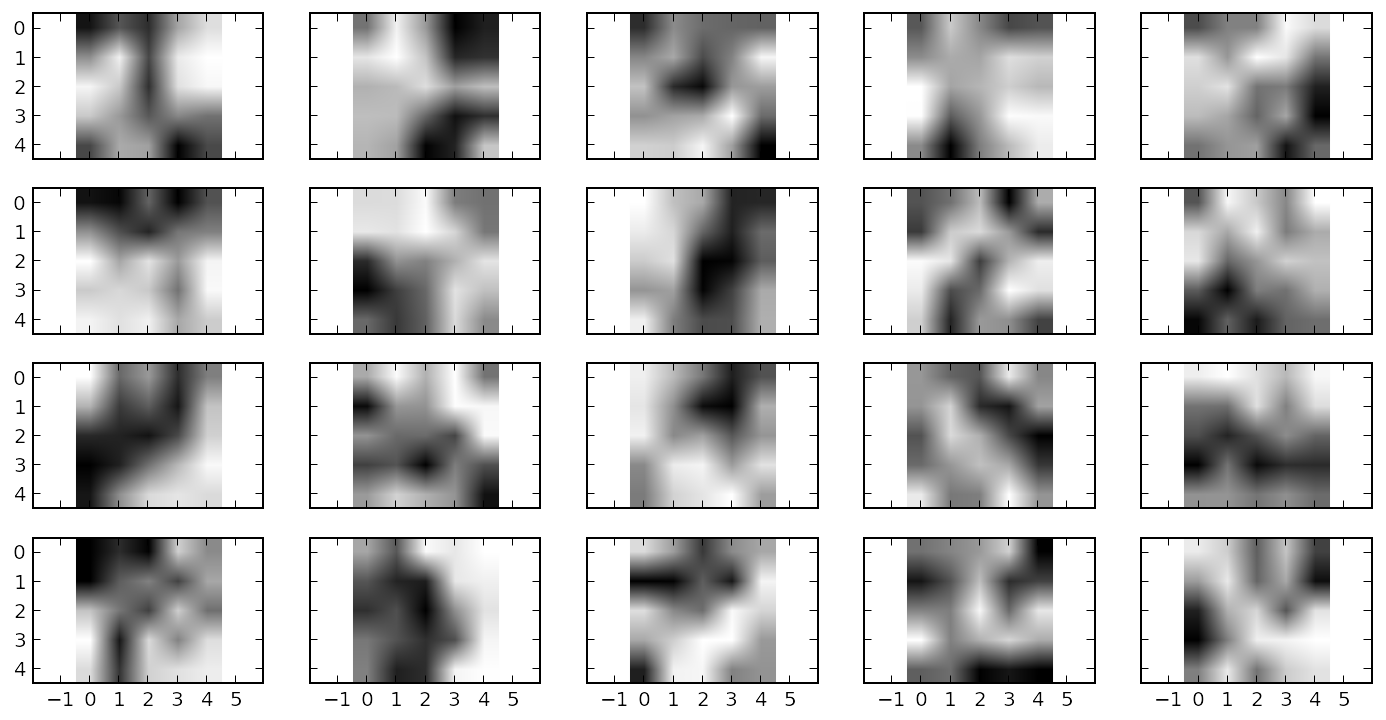

In [9]:
n_rows = 4
n_cols = 5
f, axarr = plt.subplots(n_rows, n_cols, sharex=True, sharey=True)
for i in range(n_rows):
    for j in range(n_cols):
        axarr[i, j].imshow(filters[i * n_cols + j][0, :, :], cmap='Greys_r')